<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           <img 
               src="assets/bokeh-transparent.png" 
               style="width:50px"
           >
           </a>    
       </td>
       <td style="border:none">
           <h1>Bokeh Tutorial</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>A2. Visualizing Big Data with Datashader</h2></div>

Bokeh gets its power by mirroring data from Python (or R) into the web browser.  This approach provides full flexibility and interactivity, but because of the way web browsers are designed and built, there are limitations to how much data can be shown in this way.  Most web browsers can handle up to about 100,000 or 200,000 datapoints in a Bokeh plot before they will slow down or have memory issues.  What do you do when you have larger datasets than that?

The [`datashader`](https://github.com/holoviz/datashader) library is designed to complement Bokeh by providing visualizations for very large datasets, focusing on faithfully revealing the overall distribution, not just individual data points.  datashader installs separately from bokeh, e.g. using `conda install datashader`.

<img src="assets/datashader_examples.png">

## When *not* to use datashader

* Plotting less than 1e5 or 1e6 data points
* When *every* datapoint matters; standard Bokeh will render all of them
* For full interactivity (hover tools) with *every* datapoint

## When *to* use datashader

* Actual *big data*; when Bokeh/Matplotlib have trouble
* When the *distribution* matters more than individual points
* When you find yourself sampling or binning to better understand the *distribution*


# How does datashader work?

<img src="https://raw.githubusercontent.com/holoviz/datashader/master/examples/assets/images/pipeline2.png">

* Tools like Bokeh map Data directly into an HTML/JavaScript Plot
* datashader renders Data into a screen-sized Aggregate array, from which an Image can be constructed then embedded into a Bokeh Plot 
* Only the fixed-sized Image needs to be sent to the browser, allowing millions or billions of datapoints to be used
* Every step automatically adjusts to the data, but can be customized

# Visualizations supported by datashader

Datashader currently supports:

* Scatterplots/heatmaps
* Time series
* Connected points (trajectories)
* Rasters

In each case, the output is easily embedded into Bokeh plots, with interactive resampling on pan and zoom, in notebooks or apps. Legends/hover information can be generated from the aggregate arrays, helping provide interactivity.

# Faithfully visualizing big data

Once data is large enough that individual points are not easily discerned, it is crucial that the visualization be constructed in a principled way, faithfully revealing the underlying distribution for your visual system to process.  For instance, all of these plots show the same data -- is any of them the real distribution?

<img src="assets/5_gaussians_3_ways.png">

Let's find out!  The data in the above images was created by summing five normal (Gaussian) distributions as follows:

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1)
num=10000

dists = {cat: pd.DataFrame(dict(x=np.random.normal(x,s,num),
                                y=np.random.normal(y,s,num),
                                val=val,cat=cat))
         for x,y,s,val,cat in 
         [(2,2,0.01,10,"d1"), (2,-2,0.1,20,"d2"), (-2,-2,0.5,30,"d3"), (-2,2,1.0,40,"d4"), (0,0,3,50,"d5")]}

df = pd.concat(dists,ignore_index=True)
df["cat"]=df["cat"].astype("category")
df.tail()

,x,y,val,cat
49995,-1.397579,0.610189,50,d5
49996,-2.649610,3.080821,50,d5
49997,1.933360,0.243676,50,d5
49998,4.306374,1.032139,50,d5
49999,-0.493567,-2.242669,50,d5


Here we have 50000 points, 10000 in each of five categories with associated numerical values.  This amount of data will be slow to plot directly with Bokeh or any similar libraries that copy the full data into the web browser.  Moreover, plotting data of this size with standard approaches has fatal flaws that make the above plots misrepresent the data:

* Plot A suffers from _overplotting_, with the distribution obscured by later-plotted datapoints.  
* Plot B uses smaller dots to avoid overplotting,but suffers from _oversaturation_, with differences in datapoint density not visible because all densities above a certain value show up as the same pure black color
* Plot C uses transparency to avoid oversaturation, but then suffers from _undersaturation_, with the 10,000 datapoints in the largest Gaussian (at 0,0) not visible at all.
* Bokeh can handle 50,000 points, but if the data were larger then these plots would suffer from *undersampling*, with the distribution not visible or misleading due to too few data points in sparse or zoomed-in regions.

Plots A-B also required time-consuming and error-prone manual tweaking of parameters, which is problematic if the data is large enough that the visualization is the main way for us to understand the data.

Using datashader, we can avoid all of these problems by rendering the data to an intermediate array that allows automatic ranging in all dimensions, revealing the true distribution with no parameter tweaking and very little code:

CPU times: user 432 ms, sys: 7.94 ms, total: 439 ms
Wall time: 439 ms


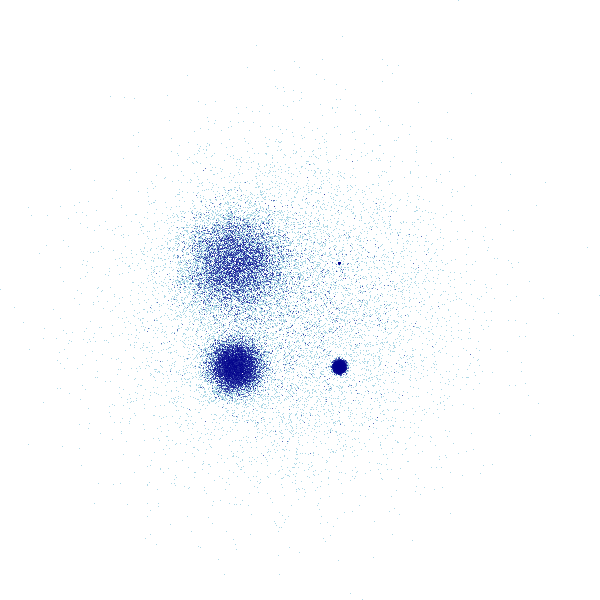

In [2]:
import datashader as ds
import datashader.transfer_functions as tf

%time tf.shade(ds.Canvas().points(df,'x','y'))

This plot reveals the structure we already know was in this data, i.e. 5 separate 2D Gaussian distributions:

<img src="assets/5_gaussians_labeled.png" width=200>

Let's look at each of the stages in the datashader pipeline in turn, to see how images like this are constructed and how they can be controlled and embedded into Bokeh plots.

# Projection and Aggregation

The first stages of the datashader pipeline are to choose:

* which variables you want to plot on the x and y axes,
* what size array do you want to aggregate the values into,
* what range of data values should that array cover, and
* what "reduction" function you want to use for aggregating:

In [3]:
canvas = ds.Canvas(plot_width=250, plot_height=250, x_range=(-4,4), y_range=(-4,4))
agg = canvas.points(df, 'x', 'y', agg=ds.count())
agg

<xarray.DataArray (y: 250, x: 250)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int32)
Coordinates:
  * x        (x) float64 -3.984 -3.952 -3.92 -3.888 ... 3.888 3.92 3.952 3.984
  * y        (y) float64 -3.984 -3.952 -3.92 -3.888 ... 3.888 3.92 3.952 3.984

Here we have chosen to plot the 'x' and 'y' columns of the dataframe on the x and y axes (unsurprisingly!), and to aggregate them by `count`.  The result is a 2D [xarray](http://xarray.pydata.org/en/stable/computation.html) of the requested size, containing one value for each eventual pixel, counting the number of datapoints that were mapped to that pixel. An xarray is similar to a Numpy or Pandas data structure and supports similar operations, but allows arbitrary multidimensional data.

Available reduction functions that you could use for aggregating include:

**`count()`**: integer count of datapoints for each pixel (the default reduction).

**`any()`**: each pixel 1 if any datapoint maps to it; 0 otherwise.
  
**`sum(column)`**: total value of the given column for all datapoints in this pixel.

**`count_cat(column)`**: count datapoints _per category_ using the given categorical column (which must be declared using [Pandas' `categorical` datatype](https://pandas-docs.github.io/pandas-docs-travis/categorical.html)). 

In [4]:
# EXERCISE: try some of these other reduction operators and see if you can understand the 
# resulting differences in the plots.  The arr can be visualized using `tf.shade(arr)` 
# for most reduction operators (other than count_cat, below).


# Transformation

Once data is in the xarray aggregate form, it can be processed in a variety of ways that provide flexibility and power.  For instance, instead of plotting all the data, we can easily plot only those bins in the 99th percentile by count:

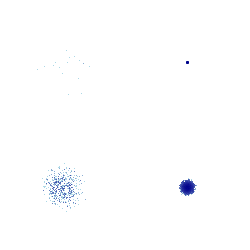

In [5]:
tf.shade(agg.where(agg>=np.percentile(agg,99)))

Or apply any [NumPy ufunc](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) to the bin values, whether or not it makes any sense:

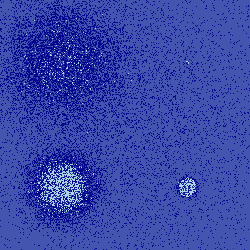

In [6]:
tf.shade(np.sin(agg))

Multiple aggregates can be made for the same plot range, allowing quite complicated queries to be expressed easily (e.g. `agg1.where(agg2>2*agg1)`).

In [7]:
# EXERCISE: try making new aggregates using other numpy ufuncs


# Colormapping

Once you have an aggregate array you want to visualize, you need to translate the values in that array into pixel colors.  datashader supports any Bokeh palette or list of colors:

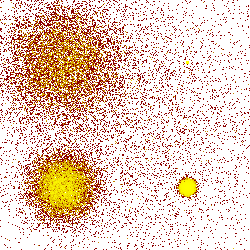

In [8]:
tf.shade(agg, cmap=["darkred", "yellow"])

We can also choose how the data values should map into colors: 'linear', 'log', or 'eq_hist':

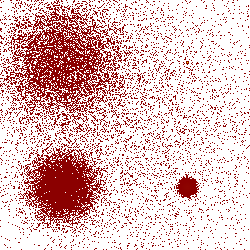

In [9]:
tf.shade(agg,cmap=["darkred", "yellow"],how='linear')

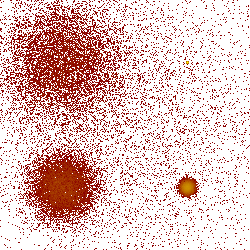

In [10]:
tf.shade(agg,cmap=["darkred", "yellow"],how='log')

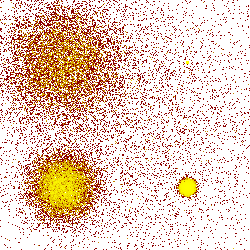

In [11]:
tf.shade(agg,cmap=["darkred", "yellow"],how='eq_hist')

Notice how little of the color range is being used for the linear case, because the high end (yellow) is used only for the single pixel with the highest density, whereas a linear mapping results in all the rest having values near the low end of the colormap.  The log mapping has similar issues, though less severe because it maps a wide range of data values into a smaller range for plotting. The `eq_hist` (default) setting correctly conveys the differences in density between the various distributions, by equalizing the histogram of pixel values such that every pixel color is used equally often.


If you have a categorical aggregate (from `count_cat`), you can now colorize the results:

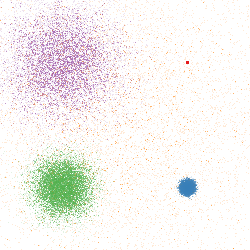

In [12]:
color_key = dict(d1='blue', d2='green', d3='red', d4='orange', d5='purple')
aggc = canvas.points(df, 'x', 'y', ds.count_cat('cat'))
tf.shade(aggc, color_key)

Here the color of each pixel is computed as a weighted average of the colors for those datapoints falling into this pixel.

If you have trouble seeing the dots, you can increase their size by "spreading" them in the final image:

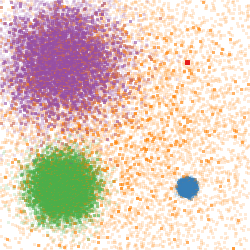

In [13]:
tf.spread(tf.shade(aggc, color_key))

`tf.spread` uses a fixed (though configurable) spreading size, while a similar command `tf.dynspread` will spread different amounts depending on density of plots in this particular view.


# Embedding

The images produced by datashader can be used with any plotting or display program, but we provide specific support for datashader in Bokeh that allows fully interactive zooming and panning to explore even extremely large datasets.
We just need to wrap the above commands into a callback function, then add it to a Bokeh figure:

In [14]:
import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

bp.output_notebook()
p = bp.figure(tools='pan,wheel_zoom,reset', x_range=(-5,5), y_range=(-5,5))

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', ds.count_cat('cat'))
    img = tf.shade(agg, color_key)
    return tf.dynspread(img, threshold=0.25)

InteractiveImage(p, image_callback)

Loading BokehJS ...

You can now see the axis values (not visible in the bare images).  If you enable wheel zoom, you should be able to zoom into any area of the plot, at which point a new datashader image will be rendered using the callback and shown in the plot.  E.g. if you zoom into the blue dot, you can see that it does contain 10,000 points, they are just so close together that they show up as only a single tiny blue spot here. Such exploration is crucial for understanding datasets with rich structure across different scales, as in most real-world data.

You can now easily overlay any other Bokeh data onto the same plot, or put map tiles in the background for geographic data in Web Mercator format (see tutorial 10).

Datashader works similarly for line plots (e.g. time series and trajectories), allowing you to use *all* the data points without needing to subsample them, even for millions or billions of points, and faithfully overlaying tens or thousands or millions of individual curves without overplotting or oversaturation problems.  It can also use raster data (such as satellite weather data), re-rasterizing it to a requested grid that can then be analyzed or colorized, and combined with other non-raster data.  For instance, if you have elevation data in raster form, and income data as individual points, you can easily make a plot of all pixels where the average income is above a certain threshold and elevation is below a certain value, a visualization that would be very difficult to express using a traditional workflow.

Hopefully it's now clear how you can use datashader to work with your large datasets.  For more information, see the [extensive notebooks](https://anaconda.org/jbednar/notebooks) online for datashader, which include examples of many different real-world datasets.

# Next Section

To explore the next topic in the appendices, click on this link: [A3 - High-Level Charting with Holoviews](A3%20-%20High-Level%20Charting%20with%20Holoviews.ipynb)

To go back to the overview, click [here](00%20-%20Introduction%20and%20Setup.ipynb).